# Optimización de Estrategia Mean Reversion para $TSLA
## Usando Particle Swarm Optimization (PSO)

Este notebook implementa la optimización de una estrategia de reversión a la media usando el algoritmo PSO.

**Objetivo**: Encontrar los parámetros óptimos que maximicen el Ratio de Sharpe.

***¿Que es el ratio de Sharpe?***
Es una herramienta que mide la rentabilidad ajustada al riesgo. Calcula cuánto "retorno extra" está generando una inversión por encima de una inversión segura (libre de riesgo), por cada unidad de riesgo (volatilidad) asumida.

## Paso 1: Importar Librerías

In [135]:
import numpy as np
import pandas as pd
import yfinance as yf
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


Ticker

In [136]:
ticker_input = 'TSLA'

## Paso 2: Descargar Datos de $TSLA (acciones de Tesla) desde ***yfinance***

In [137]:
def descargar_datos(data_from, data_to, ticker='TSLA'):
    """Descarga datos históricos de Yahoo Finance"""
    print(f" Descargando datos de {ticker}...")
    try:
        data = yf.download(ticker, auto_adjust=True, progress=False, start=data_from, end=data_to)
        
        if isinstance(data.columns, pd.MultiIndex):
             try:
                 data = data.xs(ticker, level='Ticker', axis=1)
             except:
                 pass 

        if len(data) > 0:
            print(f" Datos descargados: {len(data)} días")
            print(f"    Rango: {data.index[0].date()} a {data.index[-1].date()}")
            
            # 
            precio_ini = data['Close'].iloc[0]
            precio_fin = data['Close'].iloc[-1]
            
            # 
            if hasattr(precio_ini, 'item'): 
                precio_ini = precio_ini.item()
                precio_fin = precio_fin.item()

            print(f"    Precio: ${precio_ini:.2f} → ${precio_fin:.2f}")
            return data
            
    except Exception as e:
        print(f" Error: {e}")
        return None

# Probamos la función con el nuevo orden de argumentos
datos = descargar_datos('2025-02-15', '2025-12-01', ticker = ticker_input)

if datos is not None:
    print(datos.head())

 Descargando datos de TSLA...
 Datos descargados: 198 días
    Rango: 2025-02-18 a 2025-11-28
    Precio: $354.11 → $430.17
Price            Close        High         Low        Open    Volume
Date                                                                
2025-02-18  354.109985  359.100006  350.019989  355.010010  51631700
2025-02-19  360.559998  367.339996  353.670013  354.000000  67094400
2025-02-20  354.399994  362.299988  348.000000  361.510010  45965400
2025-02-21  337.799988  354.980011  334.420013  353.440002  74058600
2025-02-24  330.529999  342.399994  324.700012  338.140015  76052300


##  Paso 3: Definir Estrategia de Trading

In [138]:
def calcular_rsi(precios, periodo=14):
    """Calcula el Relative Strength Index (RSI)"""
    delta = precios.diff()
    ganancia = delta.where(delta > 0, 0)
    perdida = -delta.where(delta < 0, 0)
    
    avg_ganancia = ganancia.rolling(window=periodo, min_periods=1).mean()
    avg_perdida = perdida.rolling(window=periodo, min_periods=1).mean()
    
    rs = avg_ganancia / avg_perdida
    rsi = 100 - (100 / (1 + rs))
    return rsi

def backtest_estrategia(data, periodo_rsi, umbral_compra, umbral_venta, stop_loss_pct):
    """Ejecuta backtest de la estrategia de mean reversion"""
    df = data.copy()
    df['RSI'] = calcular_rsi(df['Close'], periodo=int(periodo_rsi))
    
    posicion = 0
    precio_entrada = 0
    capital = 10000
    trades = []
    
    for i in range(len(df)):
        precio_actual = df['Close'].iloc[i]
        rsi_actual = df['RSI'].iloc[i]
        
        if np.isnan(rsi_actual):
            continue
        
        # Señal de COMPRA
        if posicion == 0 and rsi_actual < umbral_compra:
            posicion = 1
            precio_entrada = precio_actual
            cantidad = capital / precio_actual
            
        # Señal de VENTA
        elif posicion == 1:
            if rsi_actual > umbral_venta:
                capital = cantidad * precio_actual
                retorno = (precio_actual - precio_entrada) / precio_entrada
                trades.append(retorno)
                posicion = 0
            elif (precio_entrada - precio_actual) / precio_entrada >= stop_loss_pct / 100:
                capital = cantidad * precio_actual
                retorno = (precio_actual - precio_entrada) / precio_entrada
                trades.append(retorno)
                posicion = 0
    
    if posicion == 1:
        capital = cantidad * df['Close'].iloc[-1]
        retorno = (df['Close'].iloc[-1] - precio_entrada) / precio_entrada
        trades.append(retorno)
    
    if len(trades) == 0:
        return -10
    
    retornos = np.array(trades)
    volatilidad = np.std(retornos)
    
    if volatilidad == 0 or np.isnan(volatilidad):
        return -10
    
    sharpe_ratio = (np.mean(retornos) / volatilidad) * np.sqrt(252)
    return sharpe_ratio

# Probar con parámetros de ejemplo
sharpe_ejemplo = backtest_estrategia(datos, 14, 30, 70, 5)
print(f"\n Sharpe Ratio con parámetros por defecto (RSI=14, Compra=30, Venta=70, SL=5%): {sharpe_ejemplo:.4f}")


 Sharpe Ratio con parámetros por defecto (RSI=14, Compra=30, Venta=70, SL=5%): 2.7428


## Paso 4: Configurar PSO

In [139]:
# Variable global para pasar datos al optimizador
datos_globales = None

def funcion_objetivo(particulas):
    """Función objetivo para PSO"""
    n_particulas = particulas.shape[0]
    fitness = np.zeros(n_particulas)
    
    for i in range(n_particulas):
        periodo_rsi = particulas[i, 0]
        umbral_compra = particulas[i, 1]
        umbral_venta = particulas[i, 2]
        stop_loss = particulas[i, 3]
        
        if umbral_compra >= umbral_venta:
            fitness[i] = 10
            continue
        
        sharpe = backtest_estrategia(datos_globales, periodo_rsi, 
                                     umbral_compra, umbral_venta, stop_loss)
        # Revisar si esta parte esta correcta
        if sharpe <= -10.0:
            fitness[i] = 100.0  # Penalización moderada
        else:
            fitness[i] = -sharpe
    
    return fitness

print(" Función objetivo configurada")

 Función objetivo configurada


##  Paso 5: EJECUTAR OPTIMIZACIÓN PSO

Este es el núcleo del algoritmo donde se ejecutan los 5 pasos:
1. **Inicialización**: Crear enjambre de partículas
2. **Evaluación**: Calcular fitness (Sharpe Ratio) de cada partícula
3. **Comunicación**: Compartir pbest y gbest
4. **Movimiento**: Actualizar velocidades y posiciones
5. **Iteración**: Repetir hasta convergencia

In [140]:
datos_globales = datos

# Configuración PSO
n_particulas = 30
n_iteraciones = 50

# Límites de búsqueda
limites_min = np.array([5, 10, 60, 1])    # [periodo_rsi, umbral_compra, umbral_venta, stop_loss]
limites_max = np.array([50, 40, 90, 10])
bounds = (limites_min, limites_max)

# Parámetros PSO
options = {
    'c1': 2.0,  # Cognitivo
    'c2': 2.0,  # Social
    'w': 0.9    # Inercia
}

print("="*70)
print(" INICIANDO OPTIMIZACIÓN PSO")
print("="*70)
print(f"Partículas: {n_particulas}")
print(f"Iteraciones: {n_iteraciones}")
print(f"Evaluaciones totales: {n_particulas * n_iteraciones}")
print("\nEjecutando:\n")

# Crear optimizador
optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particulas,
    dimensions=4,
    options=options,
    bounds=bounds
)

# Optimizar
mejor_costo, mejor_posicion = optimizer.optimize(
    funcion_objetivo,
    iters=n_iteraciones,
    verbose=True
)

mejor_sharpe = -mejor_costo

print("\n" + "="*70)
print(" OPTIMIZACIÓN COMPLETADA")
print("="*70)
print(f"\n PARÁMETROS ÓPTIMOS:")
print(f"   Periodo RSI:     {mejor_posicion[0]:.1f}")
print(f"   Umbral Compra:   {mejor_posicion[1]:.1f}")
print(f"   Umbral Venta:    {mejor_posicion[2]:.1f}")
print(f"   Stop Loss:       {mejor_posicion[3]:.1f}%")
print(f"\n Sharpe Ratio Máximo: {mejor_sharpe:.4f}")

2025-12-05 09:07:26,551 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9}


 INICIANDO OPTIMIZACIÓN PSO
Partículas: 30
Iteraciones: 50
Evaluaciones totales: 1500

Ejecutando:



pyswarms.single.global_best: 100%|█████████████████████████|50/50, best_cost=-13.7
2025-12-05 09:07:36,501 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -13.7384223549773, best pos: [22.63740783 14.6519813  77.25184734  4.96620286]



 OPTIMIZACIÓN COMPLETADA

 PARÁMETROS ÓPTIMOS:
   Periodo RSI:     22.6
   Umbral Compra:   14.7
   Umbral Venta:    77.3
   Stop Loss:       5.0%

 Sharpe Ratio Máximo: 13.7384


##  Paso 6: Visualizar Convergencia

<Figure size 1000x600 with 0 Axes>

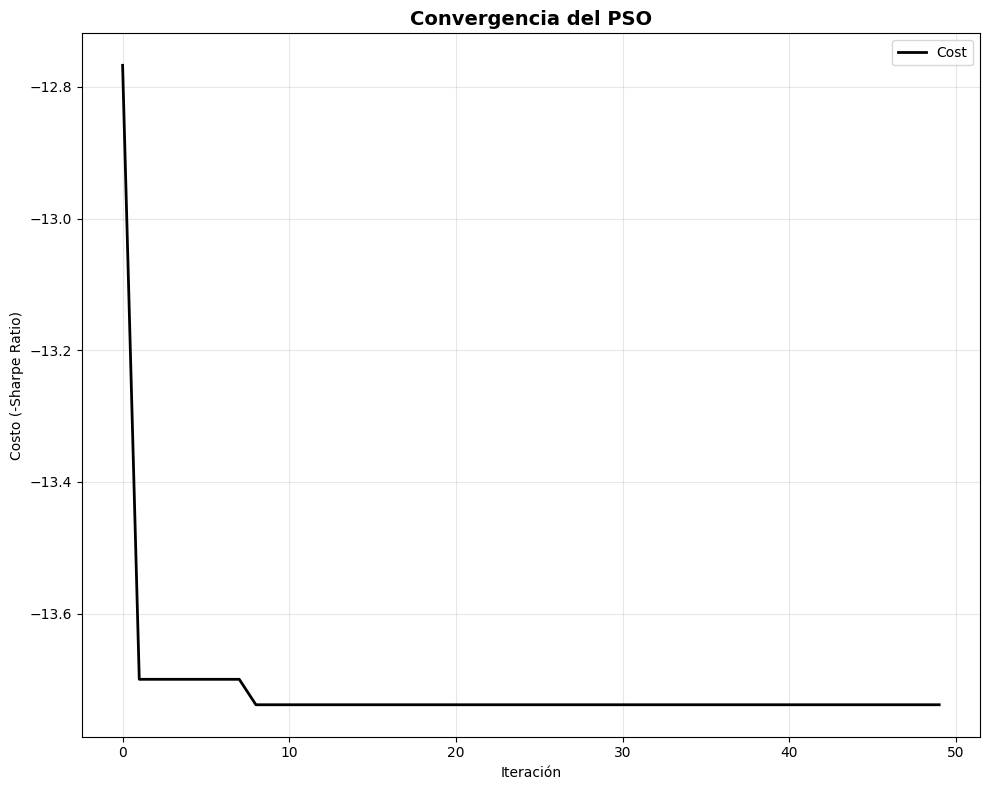

In [141]:
plt.figure(figsize=(10, 6))
plot_cost_history(cost_history=optimizer.cost_history)
plt.title('Convergencia del PSO', fontsize=14, fontweight='bold')
plt.xlabel('Iteración')
plt.ylabel('Costo (-Sharpe Ratio)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##  Paso 7: Validar Estrategia Optimizada

In [142]:
def validar_estrategia_detallada(data, params):
    """Valida la estrategia con análisis detallado"""
    periodo_rsi = int(params[0])
    umbral_compra = params[1]
    umbral_venta = params[2]
    stop_loss = params[3]
    
    df = data.copy()
    df['RSI'] = calcular_rsi(df['Close'], periodo=periodo_rsi)
    
    posicion = 0
    precio_entrada = 0
    capital = 10000
    historial_capital = [capital]
    trades = []
    
    for i in range(len(df)):
        precio_actual = df['Close'].iloc[i]
        rsi_actual = df['RSI'].iloc[i]
        
        if np.isnan(rsi_actual):
            historial_capital.append(historial_capital[-1])
            continue
        
        if posicion == 0 and rsi_actual < umbral_compra:
            posicion = 1
            precio_entrada = precio_actual
            cantidad = capital / precio_actual
            
        elif posicion == 1:
            if rsi_actual > umbral_venta or (precio_entrada - precio_actual) / precio_entrada >= stop_loss / 100:
                capital = cantidad * precio_actual
                retorno = (precio_actual - precio_entrada) / precio_entrada
                trades.append(retorno)
                posicion = 0
        
        historial_capital.append(capital if posicion == 0 else cantidad * precio_actual)
    
    if posicion == 1:
        capital = cantidad * df['Close'].iloc[-1]
    
    retornos = np.array(trades)
    retorno_total = (capital - 10000) / 10000 * 100
    
    print("\n" + "="*70)
    print(" RESULTADOS DEL BACKTEST")
    print("="*70)
    print(f"Capital Inicial:      ${10000:,.2f}")
    print(f"Capital Final:        ${capital:,.2f}")
    print(f"Retorno Total:        {retorno_total:.2f}%")
    print(f"Número de Trades:     {len(trades)}")
    
    if len(trades) > 0:
        ganadores = retornos[retornos > 0]
        perdedores = retornos[retornos < 0]
        print(f"Trades Ganadores:     {len(ganadores)} ({len(ganadores)/len(trades)*100:.1f}%)")
        print(f"Trades Perdedores:    {len(perdedores)} ({len(perdedores)/len(trades)*100:.1f}%)")
        if len(ganadores) > 0:
            print(f"Ganancia Promedio:    {np.mean(ganadores)*100:.2f}%")
        if len(perdedores) > 0:
            print(f"Pérdida Promedio:     {np.mean(perdedores)*100:.2f}%")
    
    return df, historial_capital

df_estrategia, historial_capital = validar_estrategia_detallada(datos, mejor_posicion)


 RESULTADOS DEL BACKTEST
Capital Inicial:      $10,000.00
Capital Final:        $18,199.93
Retorno Total:        82.00%
Número de Trades:     2
Trades Ganadores:     1 (50.0%)
Trades Perdedores:    1 (50.0%)
Ganancia Promedio:    95.46%
Pérdida Promedio:     -6.89%


##  Paso 8: Visualizar Resultados

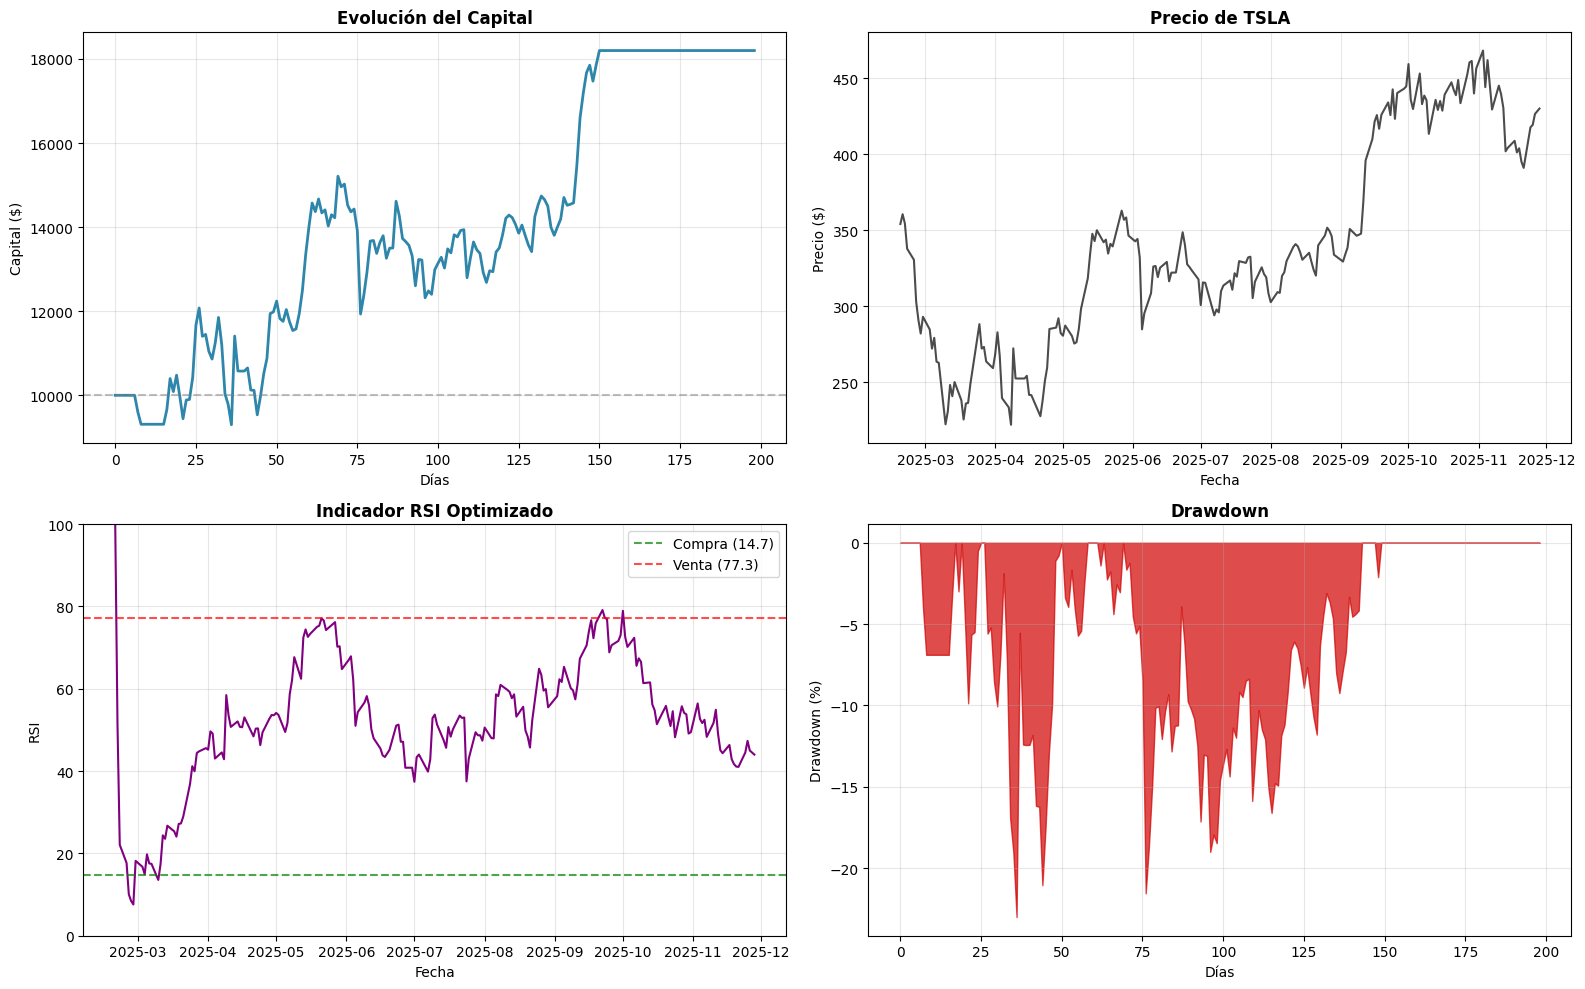

In [143]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Evolución del Capital
axes[0, 0].plot(historial_capital, linewidth=2, color='#2E86AB')
axes[0, 0].set_title('Evolución del Capital', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Días')
axes[0, 0].set_ylabel('Capital ($)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=10000, color='gray', linestyle='--', alpha=0.5)

# 2. Precio de GOOGL
axes[0, 1].plot(datos.index, datos['Close'], linewidth=1.5, color='black', alpha=0.7)
axes[0, 1].set_title(f'Precio de {ticker_input}', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fecha')
axes[0, 1].set_ylabel('Precio ($)')
axes[0, 1].grid(True, alpha=0.3)

# 3. RSI
axes[1, 0].plot(df_estrategia.index, df_estrategia['RSI'], linewidth=1.5, color='purple')
axes[1, 0].axhline(y=mejor_posicion[1], color='green', linestyle='--', alpha=0.7, label=f'Compra ({mejor_posicion[1]:.1f})')
axes[1, 0].axhline(y=mejor_posicion[2], color='red', linestyle='--', alpha=0.7, label=f'Venta ({mejor_posicion[2]:.1f})')
axes[1, 0].set_title('Indicador RSI Optimizado', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('RSI')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 100)

# 4. Drawdown
capital_serie = pd.Series(historial_capital)
drawdown = (capital_serie - capital_serie.cummax()) / capital_serie.cummax() * 100
axes[1, 1].fill_between(range(len(drawdown)), 0, drawdown, alpha=0.7, color='#D00000')
axes[1, 1].set_title('Drawdown', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Días')
axes[1, 1].set_ylabel('Drawdown (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()